# Exploratory Analysis and Regression

### 2023 Developer Survey conducted by Stack Overflow

In May 2023 over 90,000 developers responded to the annual survey about how they learn and level up, which tools they're using, and which ones they want. Here we explore developer profile and programming, scripting, and markup languages developers used in 2023. The goal is to figure out high-paying professionals and their programming preferences.

### Data Dictionary

`MainBranch` - Which of the following options best describes you today? For the purpose of this survey, a developer is "someone who writes code".

`Age` - What is your age?

`Employment` - Which of the following best describes your current employment status? Select all that apply.

`RemoteWork` - Which best describes your current work situation?

`EdLevel` - Which of the following best describes the highest level of formal education that you’ve completed?

`YearsCode` - Including any education, how many years have you been coding in total?

`YearsCodePro` - NOT including education, how many years have you coded professionally (as a part of your work)?

`DevType` - Which of the following describes your current job, the one you do most of the time? Please select only one.

`Country` - Where do you live?

`ConvertedCompYearly` -  What is your current total annual compensation (salary, bonuses, and perks, before
taxes and deductions)? We converted salaries from user currencies to USD using the exchange rate on June 2, 2023.

`LanguageHaveWorkedWith` - Which programming, scripting, and markup languages have you done extensive development work in over the past year?

`ICorPM` - Are you an individual contributor or people manager?

`WorkExp` - How many years of working experience do you have?

`Industry` - What industry is the company you work for in?

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import sys
sys.path.append("../src")

from config import url2023, url2024, file_name
from data.load_data import get_data
from data.clean_data import dataset_cleaned, dataset_cleaned1

# load row data
df = get_data(url2023, file_name)

# cleaned subset of the data
cdf = dataset_cleaned1(df)

# load row data
df2024 = get_data(url2024, file_name)

# cleaned subset of the data
cdf2024 = dataset_cleaned1(df2024)

In [3]:
cdf.columns

Index(['EdLevel', 'YearsCodePro', 'LanguageHaveWorkedWith',
       'NLanguageHaveWorkedWith', 'DevType', 'Country', 'Region',
       'ConvertedCompYearly', 'ICorPM', 'WorkExp', 'Industry'],
      dtype='object')

In [4]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25833 entries, 0 to 25832
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdLevel                  25833 non-null  object 
 1   YearsCodePro             25833 non-null  float64
 2   LanguageHaveWorkedWith   25833 non-null  object 
 3   NLanguageHaveWorkedWith  25833 non-null  float64
 4   DevType                  25833 non-null  object 
 5   Country                  25833 non-null  object 
 6   Region                   25833 non-null  object 
 7   ConvertedCompYearly      25833 non-null  float64
 8   ICorPM                   25833 non-null  object 
 9   WorkExp                  25833 non-null  float64
 10  Industry                 25833 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.2+ MB


In [5]:
cdf2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14893 entries, 0 to 14892
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdLevel                  14893 non-null  object 
 1   YearsCodePro             14893 non-null  float64
 2   LanguageHaveWorkedWith   14893 non-null  object 
 3   NLanguageHaveWorkedWith  14893 non-null  float64
 4   DevType                  14893 non-null  object 
 5   Country                  14893 non-null  object 
 6   Region                   14893 non-null  object 
 7   ConvertedCompYearly      14893 non-null  float64
 8   ICorPM                   14893 non-null  object 
 9   WorkExp                  14893 non-null  float64
 10  Industry                 14893 non-null  object 
dtypes: float64(4), object(7)
memory usage: 1.2+ MB


In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
rscaler = RobustScaler()

# calculate Z-score for annual salary
Zscore = pd.Series(scaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )
Zscore2024 = pd.Series(scaler.fit_transform(cdf2024[["ConvertedCompYearly"]]).reshape(-1), index=cdf2024.index )


# calculate Z-score for annual salary using robust percentile measures
Zrscore = pd.Series(rscaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )
Zrscore2024 = pd.Series(rscaler.fit_transform(cdf2024[["ConvertedCompYearly"]]).reshape(-1), index=cdf2024.index )


# define outliers based on Zscore
#fltr_outliers = Zscore.apply(lambda x: (x > 3) or (x < -3))

# define outliers based on Zscore robust
fltr_outliers = Zrscore.apply(lambda x: (x > 2) or (x < -2))
fltr_outliers2024 = Zrscore2024.apply(lambda x: (x > 2) or (x < -2))


# remove outliers from dataset
cdf = cdf.loc[~fltr_outliers]
cdf2024 = cdf2024.loc[~fltr_outliers2024]


In [7]:
# drop NAs

cdf.dropna(inplace=True, ignore_index=True)
cdf2024.dropna(inplace=True, ignore_index=True)

### Preprocessing Machine Learning model

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, TargetEncoder, OrdinalEncoder, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Delete records for respondents who intensively used more than 10 programming languages last year.
cdf = cdf[cdf.NLanguageHaveWorkedWith < 10].reset_index(drop=True)

### Most favorite programming languages

In [10]:
# top 20 programming languages
top20pls = cdf.LanguageHaveWorkedWith.str.get_dummies(';').sum().sort_values(ascending=False)[:20].index

In [11]:
pls = pd.get_dummies(cdf.LanguageHaveWorkedWith.str.split(';').explode().apply(lambda x: x if x in top20pls else 'Other')).groupby(level=0).sum()

In [12]:
pls2024 = pd.get_dummies(cdf2024.LanguageHaveWorkedWith.str.split(';').explode().apply(lambda x: x if x in top20pls else 'Other')).groupby(level=0).sum()

In [13]:
# Prepare the features and target
# training and testing datasets

cols = ['Region', 'LanguageHaveWorkedWith', 'NLanguageHaveWorkedWith', 'ConvertedCompYearly', 'Industry', 'ICorPM', 'WorkExp']

X_train = cdf.drop(cols, axis=1)
y_train = cdf['ConvertedCompYearly']

X_test = cdf2024.drop(cols, axis=1)
y_test = cdf2024['ConvertedCompYearly']

In [14]:
X_train = X_train.join(pls)
X_test = X_test.join(pls2024)

In [15]:
# Identify categorical and numerical columns

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Create the preprocessor with the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('poly', PowerTransformer(), ['YearsCodePro']), #PolynomialFeatures(degree=2), ['YearsCodePro']),
        ('cat', OneHotEncoder(drop="first", handle_unknown='infrequent_if_exist', min_frequency=20, sparse_output=True), categorical_cols)
    ],
    sparse_threshold=0.0,
    remainder='passthrough'
)

In [16]:
# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
#pipeline.set_output(transform="pandas")

# Fit the preprocessor on the training data
X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [17]:
#pipeline.get_feature_names_out()

In [18]:
X_train_processed.shape

(22867, 127)

### Linear Regression

In [19]:
X_train = X_train_processed
X_test = X_test_processed 

regression = LinearRegression()
regression.fit(X_train, y_train)


LinearRegression()

In [20]:
R2_train = regression.score(X_train, y_train)

In [21]:
# predict salary with the trained model on the test data set

y_pred = regression.predict(X_test)

RSS = ((y_test-y_pred)**2).sum()
TSS = ((y_train.mean()-y_test)**2).sum()
R2_test = 1.0 - RSS/TSS


### Model Evaluation


Regression Model

Model performance on train data R^2 = 0.657
Model performance on test data R^2 = 0.651


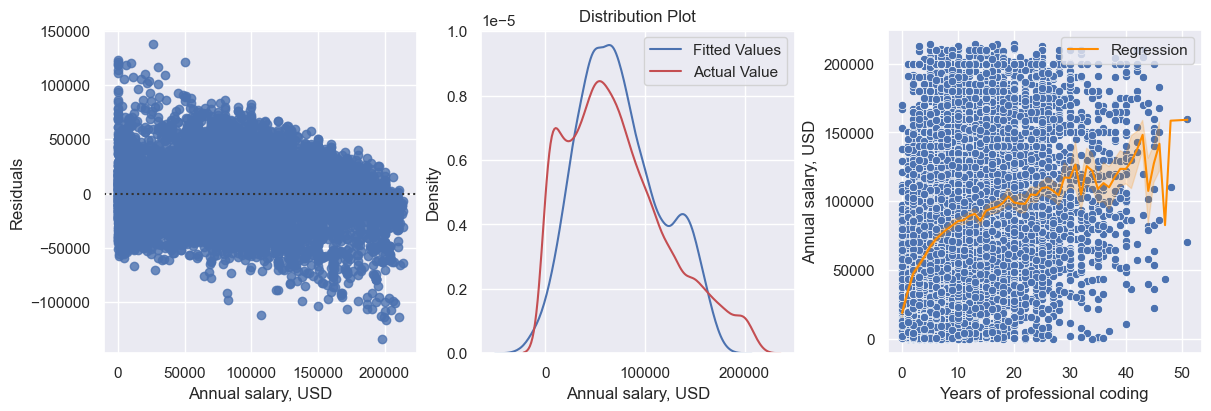

In [22]:
# Evaluate model performance on test data
width = 12
height = 4

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True)

print('\nRegression Model\n')

print("Model performance on train data R^2 = {0:.3f}".format(R2_train))
print("Model performance on test data R^2 = {0:.3f}".format(R2_test))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(width, height), constrained_layout=True)


sns.residplot(x=y_test, y=y_pred, ax=ax1)
ax1.set_xlabel("Annual salary, USD")
ax1.set_ylabel("Residuals")


sns.kdeplot(y_pred, color="b", label="Fitted Values", ax=ax2)
sns.kdeplot(y_test, color="r", label="Actual Value", ax=ax2)
ax2.legend()
ax2.set_title("Distribution Plot")
ax2.set_xlabel("Annual salary, USD")


sns.scatterplot(x="YearsCodePro", y="ConvertedCompYearly", data=cdf2024, ax=ax3)
sns.lineplot(x=cdf2024["YearsCodePro"], y=y_pred, color="darkorange", label="Regression", ax=ax3)
ax3.set_ylabel("Annual salary, USD")
ax3.set_xlabel("Years of professional coding")
ax3.legend(title="")


plt.show()
plt.close()